# Deep Join Source-Channel Coding for Wireless Image Transmission

### 1. Import and Settings

In [1]:
import datetime
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from utils.datasets import getTrainDataset, getTestDataset
from utils.lr import lrStepScheduler
from models.model import jsccEnd2EndModel
from models.model_tfc import jsccEnd2End_tfc

2023-07-07 07:02:29.837661: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 07:02:31.936793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-07 07:02:31.953714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-07 07:02:31.953949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been bu

In [3]:
checkpoint_serials = {'BW_6_SNR_7':'20230704-17031688490195', \
                      'BW_12_SNR_7':'20230705-07471688543259', \
                      'BW_6_SNR_13':'20230706-05421688622145', \
                      'BW_6_SNR_7_ft':'20230707-04261688703992', \
                      'BW_6_SNR_7_tfc':'20230707-07031688713407'}

### 2. Train

length of dataset:  781
dataset image shape: (256, 256, 3)
example image:


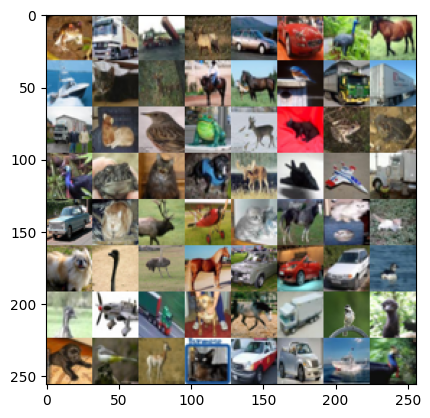

In [4]:
dataset_root = '/workspace/dataset/cifar-10-batches-py'
train_ds, shape = getTrainDataset(dataset_root, show_spec=True)

In [ ]:
# Hyperparameters

SNR_train_dB = 7
bandwidth_compression_ratio = 1/6
lr = 1e-3
num_epoch = 1000

In [ ]:
current = datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
log_dir = f'./logs/{current}'
summary_writer = tf.summary.create_file_writer(log_dir)

model = jsccEnd2EndModel(shape, bandwidth_compression_ratio, SNR_train_dB)
mse_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=lrStepScheduler(lr))

best_psnr = 0
for i in tqdm(range(num_epoch)):
    losses = []
    PSNRs = []
    for image in train_ds:
        # Forward
        with tf.GradientTape() as tape:
            output = model(image)
            loss = mse_loss(image, output)
        
        # Backward
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        # Accuracy record
        losses.append(loss)
        psnr = tf.image.psnr(image, output, max_val=255)
        PSNRs.append(psnr)

    avg_psnr = np.mean(PSNRs)
    if avg_psnr > best_psnr:
        best_psnr = avg_psnr
        model.save_weights(f'{log_dir}/jscc_awgn_7db_1/12_weights')
    with summary_writer.as_default():
        tf.summary.scalar('average loss', np.mean(losses), i+1)
        tf.summary.scalar('average PSNR', avg_psnr, i+1)


### 2-1. Fine Tuning

In [5]:
# Hyperparameters
SNR_train_dB = 7
bandwidth_compression_ratio = 6
lr = 1e-4
num_epoch = 200

# Fine Tuning
current = datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
log_dir = f'./logs/{current}'
summary_writer = tf.summary.create_file_writer(log_dir)

model_ft = jsccEnd2EndModel(shape, 1/bandwidth_compression_ratio, SNR_train_dB)
model_serial = checkpoint_serials[f'BW_{bandwidth_compression_ratio}_SNR_{SNR_train_dB}']
model_dir = f'./logs/{model_serial}/jscc_awgn_{SNR_train_dB}db_{bandwidth_compression_ratio}_weights'
model_ft.load_weights(model_dir)
mse_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

best_psnr = 0
for i in tqdm(range(num_epoch)):
    losses = []
    PSNRs = []
    for image in train_ds:
        # Forward
        with tf.GradientTape() as tape:
            output = model_ft(image)
            loss = mse_loss(image, output)
        
        # Backward
        grads = tape.gradient(loss, model_ft.trainable_weights)
        optimizer.apply_gradients(zip(grads, model_ft.trainable_weights))
        
        # Accuracy record
        losses.append(loss)
        psnr = tf.image.psnr(image, output, max_val=255)
        PSNRs.append(psnr)

    avg_psnr = np.mean(PSNRs)
    if avg_psnr > best_psnr:
        best_psnr = avg_psnr
        model_ft.save_weights(f'{log_dir}/jscc_awgn_7db_6_ft_weights')
    with summary_writer.as_default():
        tf.summary.scalar('average loss', np.mean(losses), i+1)
        tf.summary.scalar('average PSNR', avg_psnr, i+1)


  0%|          | 0/200 [00:00<?, ?it/s]2023-07-07 04:26:32.183755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [781,1,256,256,3]
	 [[{{node Placeholder/_0}}]]
2023-07-07 04:26:33.117290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-07 04:26:34.556017: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0xd476c630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-07 04:26:34.556057: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-07-07 04:26:34.559002: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR

100%|██████████| 200/200 [2:16:11<00:00, 40.86s/it]  


### 2-2. Tensorflow Compression

length of dataset:  781
dataset image shape: (256, 256, 3)
example image:


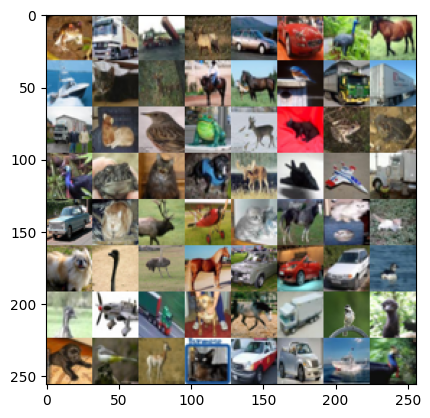

2023-07-07 07:02:55.623989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-07 07:02:55.624258: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-07 07:02:55.624478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-07 07:02:56.345011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-07 07:02:56.345348: I tensorflow/compile

In [4]:
# Datasets
dataset_root = '/workspace/dataset/cifar-10-batches-py'
train_ds, shape = getTrainDataset(dataset_root, show_spec=True)

# Hyperparameters
SNR_train_dB = 7
bandwidth_compression_ratio = 1/6
lr = 1e-3
num_epoch = 1000

In [6]:
current = datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
log_dir = f'./logs/{current}'
summary_writer = tf.summary.create_file_writer(log_dir)

model = jsccEnd2End_tfc(shape, bandwidth_compression_ratio, SNR_train_dB)
mse_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=lrStepScheduler(lr))

best_psnr = 0
for i in tqdm(range(num_epoch)):
    losses = []
    PSNRs = []
    for image in train_ds:
        # Forward
        with tf.GradientTape() as tape:
            output = model(image)
            loss = mse_loss(image, output)
        
        # Backward
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        # Accuracy record
        losses.append(loss)
        psnr = tf.image.psnr(image, output, max_val=255)
        PSNRs.append(psnr)

    avg_psnr = np.mean(PSNRs)
    if avg_psnr > best_psnr:
        best_psnr = avg_psnr
        model.save_weights(f'{log_dir}/jscc_awgn_7db_6_tfc_weights')
    with summary_writer.as_default():
        tf.summary.scalar('average loss', np.mean(losses), i+1)
        tf.summary.scalar('average PSNR', avg_psnr, i+1)


  0%|          | 0/1000 [00:00<?, ?it/s]2023-07-07 07:03:28.393472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-07 07:03:31.790008: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0xc7ffc090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-07 07:03:31.790044: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-07-07 07:03:31.797625: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-07 07:03:31.910292: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  4%|▎         | 35/1000 [43:20<19:55:10, 74.31s/it]


KeyboardInterrupt: 

### 2-3. Full Training (TFC)

In [ ]:
# Datasets
dataset_root = '/workspace/dataset/cifar-10-batches-py'
train_ds, shape = getTrainDataset(dataset_root, show_spec=True)

# Hyperparameters
SNR_train_dB = [1, 4, 7, 13, 19]
bandwidth_compression_ratio = [6, 12]
lr = 1e-3
num_epoch = 700

In [ ]:
for BW in bandwidth_compression_ratio:
    for SNR in SNR_train_dB:
        log_dir = f'./logs/BW{BW}_{SNR}dB'
        summary_writer = tf.summary.create_file_writer(log_dir)
        model = jsccEnd2End_tfc(shape, 1/BW, SNR)
        mse_loss = tf.keras.losses.MeanSquaredError()
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        best_psnr = 0

        for i in tqdm(range(num_epoch)):
            losses = []
            PSNRs = []
            for image in train_ds:
                # Forward
                with tf.GradientTape() as tape:
                    output = model(image)
                    loss = mse_loss(image, output)
                # Backward
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
                # Accuracy
                losses.append(loss)
                PSNRs.append(tf.image.psnr(image, output, max_val=255))

            # Save Model
            avg_psnr = np.mean(PSNRs)
            if avg_psnr > best_psnr:
                best_psnr = avg_psnr
                model.save_weights(f'{log_dir}/weights')
            # Tensorboard Record
            with summary_writer.as_default():
                tf.summary.scalar('average loss', np.mean(losses), i+1)
                tf.summary.scalar('average PSNR', avg_psnr, i+1)


### 3. Test

In [ ]:
checkpoint_dir = f'{log_dir}/jscc_awgn_7db_1/12_weights'
loader = jsccEnd2EndModel(shape, bandwidth_compression_ratio, SNR_train_dB)
loader.load_weights(checkpoint_dir)

for image in train_ds:
    output = loader(image)
    image = np.reshape(image, (256, 256, 3)).astype(np.uint8)
    output = np.reshape(output, (256, 256, 3)).astype(np.uint8)

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(output)
    plt.show()
    break


In [ ]:
dataset_root = '/workspace/dataset/cifar-10-batches-py'
test_ds, shape = getTestDataset(dataset_root)

BW = 6
train_SNRs = [7, 13]
test_SNRs = [1, 4, 7, 10, 13, 16, 19 ,22, 25]

for train_SNR in train_SNRs:
    model_serial = checkpoint_serials[f'BW_{BW}_SNR_{train_SNR}']
    model_dir = f'./logs/{model_serial}/jscc_awgn_{train_SNR}db_{BW}_weights'
    avg_PSNR = []

    for test_SNR in tqdm(test_SNRs):
        test_model = jsccEnd2EndModel(shape, 1/BW, test_SNR)
        test_model.load_weights(model_dir)
        PSNRs = []
        for image in test_ds:
            output = test_model(image)
            PSNRs.append(tf.image.psnr(image, output, max_val=255))
        avg_PSNR.append(np.mean(PSNRs))    
    plt.plot(test_SNRs, avg_PSNR, '-o', label=f'deepJSCC (SNR_train = {train_SNR}dB)')

plt.title(f'AWGN Channel (k/n = 1/{BW})')
plt.xlabel('SNR_test (dB)')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.show()


### 3-1. full_eval

2023-07-14 05:39:13.650942: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 05:39:15.162518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-14 05:39:15.167007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-14 05:39:15.167223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been bu

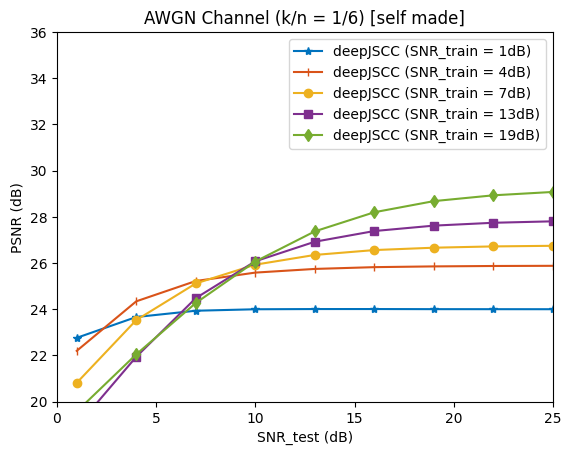

In [9]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils.datasets import getTestDataset
from models.model_tfc import jsccEnd2End_tfc

dataset_root = '/workspace/dataset/cifar-10-batches-py'
test_ds, shape = getTestDataset(dataset_root)

BW = 6
train_SNRs = [1, 4, 7, 13, 19]
plot_color = ['#0072bd', '#d95319', '#edb120', '#7e2f8e', '#77ac30']
plot_marker = ['-*', '-|', '-o', '-s', '-d']
test_SNRs = [1, 4, 7, 10, 13, 16, 19 ,22, 25]

for i, train_SNR in enumerate(train_SNRs):
    model_dir = f'./logs/BW{BW}_{train_SNR}dB/weights'
    avg_PSNR = []

    for test_SNR in tqdm(test_SNRs):
        test_model = jsccEnd2End_tfc(shape, 1/BW, test_SNR)
        test_model.load_weights(model_dir)
        PSNRs = []
        for image in test_ds:
            output = test_model(image)
            PSNRs.append(tf.image.psnr(image, output, max_val=255))
        avg_PSNR.append(np.mean(PSNRs))    
    plt.plot(test_SNRs, avg_PSNR, plot_marker[i], color=plot_color[i], label=f'deepJSCC (SNR_train = {train_SNR}dB)')

plt.title(f'AWGN Channel (k/n = 1/{BW}) [self made]')
plt.xlabel('SNR_test (dB)')
plt.ylabel('PSNR (dB)')
plt.axis((0, 25, 20, 36))
plt.legend()
plt.show()


### 3-3 Check Overfitting

In [ ]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils.datasets import getTrainDataset
from models.model_tfc import jsccEnd2End_tfc

dataset_root = '/workspace/dataset/cifar-10-batches-py'
test_ds, shape = getTrainDataset(dataset_root)

BW = 6
train_SNRs = [1, 4, 7, 13, 19]
plot_color = ['#0072bd', '#d95319', '#edb120', '#7e2f8e', '#77ac30']
plot_marker = ['-*', '-|', '-o', '-s', '-d']
test_SNRs = [1, 4, 7, 10, 13, 16, 19 ,22, 25]

for i, train_SNR in enumerate(train_SNRs):
    model_dir = f'./logs/BW{BW}_{train_SNR}dB/weights'
    avg_PSNR = []

    for test_SNR in tqdm(test_SNRs):
        test_model = jsccEnd2End_tfc(shape, 1/BW, test_SNR)
        test_model.load_weights(model_dir)
        PSNRs = []
        for image in test_ds:
            output = test_model(image)
            PSNRs.append(tf.image.psnr(image, output, max_val=255))
        avg_PSNR.append(np.mean(PSNRs))    
    plt.plot(test_SNRs, avg_PSNR, plot_marker[i], color=plot_color[i], label=f'deepJSCC (SNR_train = {train_SNR}dB)')

plt.title(f'AWGN Channel (k/n = 1/{BW}) [self made]')
plt.xlabel('SNR_test (dB)')
plt.ylabel('PSNR (dB)')
plt.axis((0, 25, 20, 36))
plt.legend()
plt.show()
